In [1]:
#Import the libraries we'll need
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
%matplotlib inline

In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def extract_data(file):
    d = unpickle(file)
    dim = int(np.sqrt(d['data'].shape[1]/3))
    d['data'] = d['data'].reshape((-1,3,dim,dim))
    d['data'] = np.transpose(d['data'],axes=(0,2,3,1))
    return d['data'],np.array(d['labels'])

In [3]:
X_train, Y_train = extract_data('cifar-10-batches-py/data_batch_1')
X_val, Y_val = extract_data('cifar-10-batches-py/data_batch_2')
X_test, Y_test = extract_data('cifar-10-batches-py/data_batch_3')
print "X_train.shape = {}, Y_train.shape = {}".format(
    X_train.shape,Y_train.shape)

X_train.shape = (10000, 32, 32, 3), Y_train.shape = (10000,)


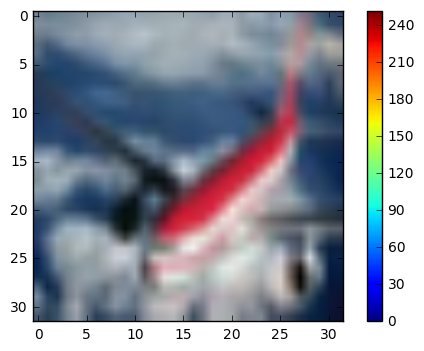

In [4]:
i = np.random.randint(X_train.shape[0])
plt.figure()
plt.imshow(X_train[i,:,:,:])
plt.colorbar()
plt.show()

In [5]:
#normalize the data
X_train = 1.0*X_train/255
X_val = 1.0*X_val/255
X_test = 1.0*X_test/255

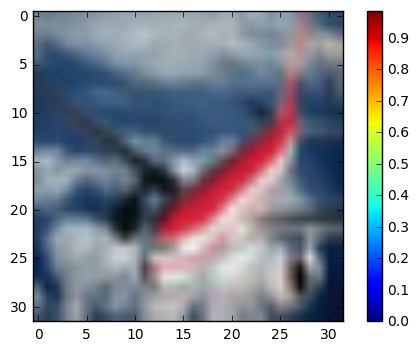

In [6]:
plt.figure()
plt.imshow(X_train[i,:,:,:])
plt.colorbar()
plt.show()

In [7]:
def conv2D(x, dims=[3,3], filters=32, strides=[1,1], 
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d', reuse=False):
    
    with tf.variable_scope(scope,reuse=reuse):
        
        s = x.get_shape().as_list()
        shape = dims +[s[3],filters]
        
        W = tf.Variable(tf.random_normal(shape=shape,stddev=std),
            name='W')
        b = tf.Variable(tf.ones([filters])*std, name='b')
    
        o = tf.nn.convolution(x, W, padding, strides=strides)
        
        o = o+b
        
        a = activation(o)
        
        return a
    
def fullyConnected(x,output_units=100,activation=tf.identity,std=1e-3,
                  scope='fc',reuse=False):
    with tf.variable_scope(scope,reuse=reuse):
        
        s = x.get_shape().as_list()
        shape = [s[1],output_units]
        
        W = tf.Variable(tf.random_normal(shape, stddev=std))
        b = tf.Variable(tf.ones([shape[1]])*std)

        h = tf.matmul(x,W)+b
        a = activation(h)
        return a
    
def get_batch(X,Y,N,n=32):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds]
    y = Y[inds]
    return x,y

In [8]:
train_steps = 10000
N = X_train.shape[0]
Nbatch = 64
print_step = 100
W = X_train.shape[1]
H = W
C = 3
filters = 4
dims = [5,5]
strides = [1,1]
act = tf.nn.relu
std=1e-2
num_classes=10
lr=1e-2
momentum=0.9
l2_coeff = 1.0

In [9]:
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int32)

o = conv2D(x,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope='conv_1')

# o = conv2D(o,dims=dims,filters=filters,strides=strides,std=std,
#            activation=act, scope='conv_2')

o = conv2D(o,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope='conv_3')

s = o.get_shape().as_list()
o = tf.reshape(o,[-1,s[1]*s[2]*s[3]])

o = fullyConnected(o,num_classes,scope='fc_logits')

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o,labels=y))

var_list = tf.trainable_variables()

l2_reg = 0
for v in var_list:
    l2_reg += tf.reduce_mean(tf.square(v))
    
l2_reg = (1.0/len(var_list))*l2_coeff*l2_reg
loss = loss + l2_reg

In [10]:
opt = tf.train.MomentumOptimizer(lr,momentum)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [11]:
train_hist = []
val_hist = []
sess = tf.Session()
sess.run(init)
xb,yb = get_batch(X_train,Y_train,N,n=Nbatch)

In [12]:
for i in range(train_steps):
    xb,yb = get_batch(X_train,Y_train,N,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_val,Y_val,N,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print "iter: {} Train: {}, Val: {}".format(i,l,lval)
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 2.30258250237, Val: 2.30266141891
iter: 100 Train: 2.2735850811, Val: 2.28505754471
iter: 200 Train: 1.8060541153, Val: 1.91878831387
iter: 300 Train: 2.09435391426, Val: 2.29842972755
iter: 400 Train: 1.75077056885, Val: 1.95526146889
iter: 500 Train: 2.01315283775, Val: 1.71909630299
iter: 600 Train: 1.69831132889, Val: 1.91365373135
iter: 700 Train: 1.79302346706, Val: 1.96949088573
iter: 800 Train: 1.84570527077, Val: 1.89373588562
iter: 900 Train: 1.75682628155, Val: 1.84292006493
iter: 1000 Train: 2.44597458839, Val: 2.03505706787
iter: 1100 Train: 1.67928004265, Val: 1.9298081398
iter: 1200 Train: 1.66497123241, Val: 1.88258552551
iter: 1300 Train: 2.29162311554, Val: 2.14144873619
iter: 1400 Train: 1.77477622032, Val: 1.97711479664
iter: 1500 Train: 1.96984171867, Val: 1.97338843346
iter: 1600 Train: 1.8250887394, Val: 2.04731988907
iter: 1700 Train: 1.59032535553, Val: 1.75692760944
iter: 1800 Train: 1.8230650425, Val: 1.91755974293
iter: 1900 Train: 1.439944744

KeyboardInterrupt: 

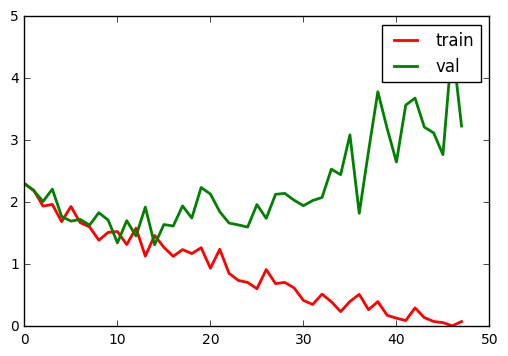

In [13]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

In [17]:
a = sess.run(o,{x:xb,y:yb})

In [18]:
print a[:2]
print a.shape
print a[0]/np.sum(a[0])

[[ 24.29699135   2.67810178   8.47763157  -5.70062828  -1.15613735
  -25.35452461 -18.71634865 -11.20112133  32.93395615  -6.33817959]
 [ -4.72514915   5.89069128  -8.03495312  -3.13057494 -13.79018593
   -9.68714714  -2.76460671  -3.01525569  26.35907936  12.9116745 ]]
(64, 10)
[-302.74188232  -33.36929703 -105.63175964   71.03014374   14.4055357
  315.91879272  233.20675659  139.56660461 -410.35894775   78.97407532]
